In [1]:
import os.path
os.environ["PYTORCH_USE_CUDA_DSA"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import torch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import resample
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [2]:
from my_model import CustomModel, PT5_classification_model, train_per_protein, create_dataset, load_model_, save_model

[2024-05-10 00:53:36,133] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
from utilites import *

In [4]:
#os.chdir("./")
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [5]:
vdjdb = pd.read_csv('../data/vdjdb_full.txt', sep='\t', low_memory=False)

In [6]:
vdjdb.head()

,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,species,mhc.a,mhc.b,...,meta.replica.id,meta.clone.id,meta.epitope.id,meta.tissue,meta.donor.MHC,meta.donor.MHC.method,meta.structure.id,cdr3fix.alpha,cdr3fix.beta,vdjdb.score
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*02:01,HLA-A*24:02;HLA-B*08:01,HLA-B*5701...",NaN,NaN,"{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2
1,NaN,NaN,NaN,CASSFEAGQGFFSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*01:01,HLA-A*02:01;HLA-B*08:01,HLA-B*57:0...",NaN,NaN,NaN,"{""cdr3"": ""CASSFEAGQGFFSNQPQHF"", ""cdr3_old"": ""C...",2
2,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*02,HLA-A*24:02;HLA-B*08:01,HLA-B*15;HLA-...",NaN,NaN,"{""cdr3"": ""CAVPSGAGSYQLTF"", ""cdr3_old"": ""CAVPSG...","{""cdr3"": ""CASSFEPGQGFYSNQPQHF"", ""cdr3_old"": ""C...",2
3,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*01:01,HLA-A*02:01;HLA-B*08:01,HLA-B*57:0...",NaN,NaN,"{""cdr3"": ""CAVKASGSRLT"", ""cdr3_old"": ""CAVKASGSR...","{""cdr3"": ""CASSYEPGQVSHYSNQPQHF"", ""cdr3_old"": ""...",2
4,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*01:01,HLA-A*02:01;HLA-B*08:01,HLA-B*57:0...",NaN,NaN,"{""cdr3"": ""CAYRPPGTYKYIF"", ""cdr3_old"": ""CAYRPPG...","{""cdr3"": ""CASSALASLNEQFF"", ""cdr3_old"": ""CASSAL...",2


In [7]:
vdjdb.columns


Index(['cdr3.alpha', 'v.alpha', 'j.alpha', 'cdr3.beta', 'v.beta', 'd.beta',
       'j.beta', 'species', 'mhc.a', 'mhc.b', 'mhc.class', 'antigen.epitope',
       'antigen.gene', 'antigen.species', 'reference.id',
       'method.identification', 'method.frequency', 'method.singlecell',
       'method.sequencing', 'method.verification', 'meta.study.id',
       'meta.cell.subset', 'meta.subject.cohort', 'meta.subject.id',
       'meta.replica.id', 'meta.clone.id', 'meta.epitope.id', 'meta.tissue',
       'meta.donor.MHC', 'meta.donor.MHC.method', 'meta.structure.id',
       'cdr3fix.alpha', 'cdr3fix.beta', 'vdjdb.score'],
      dtype='object')

In [8]:
vdjb_alpha = vdjdb[['cdr3.alpha', 'antigen.epitope']].dropna()
print(vdjb_alpha.shape)
vdjb_alpha = vdjb_alpha[vdjb_alpha['antigen.epitope'] != 'KLGGALQAK']
print(vdjb_alpha.shape)

(38049, 2)
(24075, 2)


In [9]:
le = MyLabelEncoder()
groups = vdjb_alpha['antigen.epitope'].value_counts().index

le.fit(groups)
groups
le.transform(groups)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [10]:
vdjb_alpha['antigen.epitope'].value_counts()[vdjb_alpha['antigen.epitope'].value_counts()>400].shape[0]

15

In [11]:
vdjb_alpha['antigen.epitope']= le.transform(vdjb_alpha['antigen.epitope'])
vdjb_alpha

,cdr3.alpha,antigen.epitope
0,CIVRAPGRADMRF,210
2,CAVPSGAGSYQLTF,210
3,CAVKASGSRLT,210
4,CAYRPPGTYKYIF,210
5,CIVRAPGRADMRF,305
...,...,...
62172,CMDEGGSNYKLTF,69
62173,CSLYNNNDMRF,69
62174,CALSTDSWGKLQF,150
62175,CAPQGATNKLIF,150


In [12]:
vdjb_alpha = vdjb_alpha[vdjb_alpha['antigen.epitope']<=15]

<BarContainer object of 16 artists>

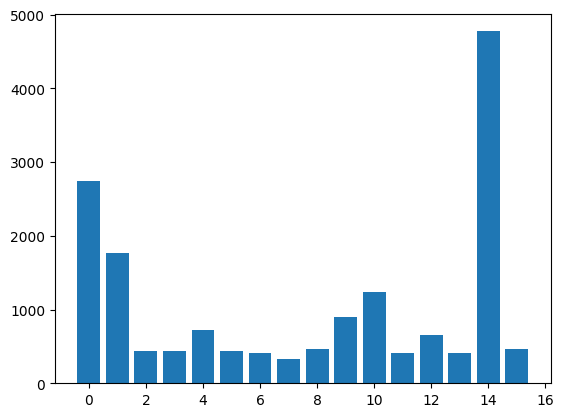

In [13]:
plt.bar(vdjb_alpha['antigen.epitope'].unique(), vdjb_alpha['antigen.epitope'].value_counts())

In [14]:
alpha_data = vdjb_alpha.reset_index(drop=True)

In [15]:
alpha_data['antigen.epitope'].value_counts()

0     4774
1     2746
2     1764
3     1235
4      894
5      729
6      661
7      470
8      460
9      437
10     436
11     431
12     417
13     410
14     405
15     333
Name: antigen.epitope, dtype: int64

In [16]:
alpha_resampl = balance_majority(alpha_data, 'antigen.epitope', max_count=1500)

In [17]:
alpha_test = alpha_resampl.sample(frac=0.15, random_state=42)
alpha_train = alpha_resampl.drop(alpha_test.index)

alpha_train

,cdr3.alpha,antigen.epitope
6090,CAVSPNDYKLSF,3
6099,CAVSAASGGSYIPTF,3
6109,CVVNVNNARLMF,3
6110,CAASETSYDKVIF,3
6116,CAGVRYGQNFVF,3
...,...,...
7727,CAFPWGAGSYQLTF,2
10643,CILRGEFGNEKLTF,2
11672,CAVRDSASGTYKYIF,2
10086,CAVSKDSSNTGKLIF,2


In [18]:
alpha_train['cdr3.alpha']  = alpha_train['cdr3.alpha'].apply(add_spaces)
alpha_test['cdr3.alpha']  = alpha_test['cdr3.alpha'].apply(add_spaces)

In [19]:
ans = alpha_test['antigen.epitope']
alpha_test = alpha_test.drop(columns=['antigen.epitope'])

In [20]:
N_LABELS = alpha_train['antigen.epitope'].nunique()


In [21]:
N_LABELS

16

### Prottrans

In [22]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(alpha_train, test_size=0.2, random_state=42)

In [23]:
train_df = train_df.rename({'cdr3.alpha': 'sequence', 'antigen.epitope': 'label'}, axis=1)
val_df = val_df.rename({'cdr3.alpha': 'sequence', 'antigen.epitope': 'label'}, axis=1)
train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
val_df["sequence"]=val_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    
val_df

,sequence,label
16303,C A V N P Q T T D S W G K L Q F,7
14343,C V G T P D Y Q L I W,13
14925,C A A T N T G T A S K L T F,15
12266,C A A S R G S N N R I F F,9
11566,C A V Y P G A N N L F F,5
...,...,...
1684,C A V P S G G Y N K L I F,1
15231,C V V T P R G S T L G R L Y F,7
9765,C A L S D W E S G G S Y I P T F,2
3673,C A M S G E G D S W G K L Q F,0


In [24]:
tokenizer, model, history = train_per_protein(train_df, val_df, num_labels=N_LABELS, epochs=9)

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.19.layer.1.EncDecAttention.q.weight', 'decoder.block.20.layer.2.layer_norm.weight', 'decoder.block.13.layer.2.DenseReluDense.wi.weight', 'decoder.block.13.layer.0.SelfAttention.v.weight', 'decoder.block.4.layer.1.EncDecAttention.v.weight', 'decoder.block.9.layer.1.layer_norm.weight', 'decoder.block.22.layer.1.EncDecAttention.k.weight', 'decoder.block.16.layer.2.DenseReluDense.wi.weight', 'decoder.block.5.layer.2.layer_norm.weight', 'decoder.block.17.layer.0.SelfAttention.v.weight', 'decoder.block.20.layer.1.EncDecAttention.o.weight', 'decoder.block.21.layer.0.layer_norm.weight', 'decoder.block.13.layer.0.SelfAttention.o.weight', 'decoder.block.0.layer.1.layer_norm.weight', 'decoder.block.11.layer.2.layer_norm.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.8.layer.2.DenseReluDense.wi.weight', 'decoder.block.21.layer.1.layer_norm

ProtT5_Classfier
Trainable Parameter: 1209207824
ProtT5_LoRA_Classfier
Trainable Parameter: 3573776

[2024-05-09 23:29:20,471] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-05-09 23:29:20,472] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
[2024-05-09 23:29:20,502] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.14.0, git-hash=unknown, git-branch=unknown
[2024-05-09 23:29:23,261] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False


Using /home/akabalina/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/akabalina/.cache/torch_extensions/py39_cu117/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module cpu_adam...


ninja: no work to do.
Time to load cpu_adam op: 3.4616458415985107 seconds
[2024-05-09 23:29:30,142] [INFO] [logging.py:96:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adamw as basic optimizer
[2024-05-09 23:29:30,144] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2024-05-09 23:29:30,191] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
[2024-05-09 23:29:30,192] [INFO] [utils.py:56:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
[2024-05-09 23:29:30,193] [INFO] [logging.py:96:log_dist] [Rank 0] Creating torch.float32 ZeRO stage 2 optimizer
[2024-05-09 23:29:30,194] [INFO] [stage_1_and_2.py:149:__init__] Reduce bucket size 200000000
[2024-05-09 23:29:30,195] [INFO] [stage_1_and_2.py:150:__init__] Allgather bucket size 200000000
[2024-05-09 23:29:30,195] [INFO] [stage_1_and_2.py:151:__ini

***** Running training *****
  Num examples = 8036
  Num Epochs = 9
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 2
  Total optimization steps = 9036
  Number of trainable parameters = 3573776


Adam Optimizer #0 is created with AVX512 arithmetic capability.
Config: alpha=0.000300, betas=(0.900000, 0.999000), weight_decay=0.000000, adam_w=1


Epoch,Training Loss,Validation Loss,Accuracy
0,2.189000,1.966210,0.371827
1,1.901300,1.860822,0.409159
2,1.804700,1.803576,0.426083
3,1.718000,1.776897,0.440020
4,1.654500,1.763870,0.440518
5,1.593900,1.772316,0.445993
6,1.543100,1.760830,0.435540
7,1.478700,1.783646,0.451468
8,1.417100,1.798362,0.439024


***** Running Evaluation *****
  Num examples = 2009
  Batch size = 16


[2024-05-09 23:43:54,402] [INFO] [logging.py:96:log_dist] [Rank 0] step=2000, skipped=0, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-05-09 23:43:54,406] [INFO] [timer.py:260:stop] epoch=0/micro_step=4000/global_step=2000, RunningAvgSamplesPerSec=20.7498917613824, CurrSamplesPerSec=20.621343805502807, MemAllocated=4.53GB, MaxMemAllocated=8.19GB


***** Running Evaluation *****
  Num examples = 2009
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2009
  Batch size = 16


[2024-05-09 23:57:43,086] [INFO] [logging.py:96:log_dist] [Rank 0] step=4000, skipped=0, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-05-09 23:57:43,090] [INFO] [timer.py:260:stop] epoch=0/micro_step=8000/global_step=4000, RunningAvgSamplesPerSec=20.743245056665604, CurrSamplesPerSec=20.071933572170753, MemAllocated=4.53GB, MaxMemAllocated=8.19GB


***** Running Evaluation *****
  Num examples = 2009
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2009
  Batch size = 16


[2024-05-10 00:11:31,112] [INFO] [logging.py:96:log_dist] [Rank 0] step=6000, skipped=0, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-05-10 00:11:31,117] [INFO] [timer.py:260:stop] epoch=0/micro_step=12000/global_step=6000, RunningAvgSamplesPerSec=20.744703364801115, CurrSamplesPerSec=20.41619937694704, MemAllocated=4.53GB, MaxMemAllocated=8.19GB


***** Running Evaluation *****
  Num examples = 2009
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2009
  Batch size = 16


[2024-05-10 00:25:18,850] [INFO] [logging.py:96:log_dist] [Rank 0] step=8000, skipped=0, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-05-10 00:25:18,852] [INFO] [timer.py:260:stop] epoch=0/micro_step=16000/global_step=8000, RunningAvgSamplesPerSec=20.747776718756224, CurrSamplesPerSec=20.792973337076194, MemAllocated=4.53GB, MaxMemAllocated=8.19GB


***** Running Evaluation *****
  Num examples = 2009
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2009
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




In [25]:
save_model(model, '../models_ft/prottrans_alp_epit.pth')

In [26]:
tock, model_re = load_model_('../models_ft/prottrans_alp_epit.pth', num_labels=N_LABELS)

loading configuration file config.json from cache at /home/akabalina/.cache/huggingface/hub/models--Rostlab--prot_t5_xl_uniref50/snapshots/973be27c52ee6474de9c945952a8008aeb2a1a73/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 16384,
  "d_kv": 128,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 32,
  "num_layers": 24,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.26.1",
  "use_cache": true,
  "vocab_size": 128
}

loading weights file pytorch_model.bin from cache at /home/akabalina/.cache/huggingface/hub/models--Rostlab--p

ProtT5_Classfier
Trainable Parameter: 1209207824
ProtT5_LoRA_Classfier
Trainable Parameter: 3573776



In [27]:
alpha_test

,cdr3.alpha
9353,C A I G D Q T G A N N L F F
9547,C A V S D H S N N A R L M F
15422,C V V N K E D D M R F
5038,C A T F M E Y G N K L V F
10381,C A Y R V D N A R L M F
...,...
2935,C I L G N N N D M R F
16563,C A G Q N Y G G S Q G N L I F
9282,C A A M E T S Y D K V I F
12616,C A L G G G S N Y Q L I W


In [28]:
alpha_test=alpha_test.rename({'cdr3.alpha': 'sequence'}, axis=1)
alpha_test["sequence"]=alpha_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)

alpha_test.head(5)

,sequence
9353,C A I G D Q T G A N N L F F
9547,C A V S D H S N N A R L M F
15422,C V V N K E D D M R F
5038,C A T F M E Y G N K L V F
10381,C A Y R V D N A R L M F


In [29]:
test_set=create_dataset(tock, list(alpha_test['sequence']),list(ans))

test_set = test_set.with_format("torch", device=device)
test_dataloader = DataLoader(test_set, batch_size=8, shuffle=False)


model_re.eval()

predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #add batch results(logits) to predictions
        predictions += model_re(input_ids, attention_mask=attention_mask).logits.tolist()

100%|██████████| 222/222 [00:15<00:00, 14.33it/s]


In [30]:
predictions= [item.argmax() for item in np.array(predictions)]
print("F1 score: ", f1_score(list(ans), predictions, average='macro'))

F1 score:  0.40608600387049676


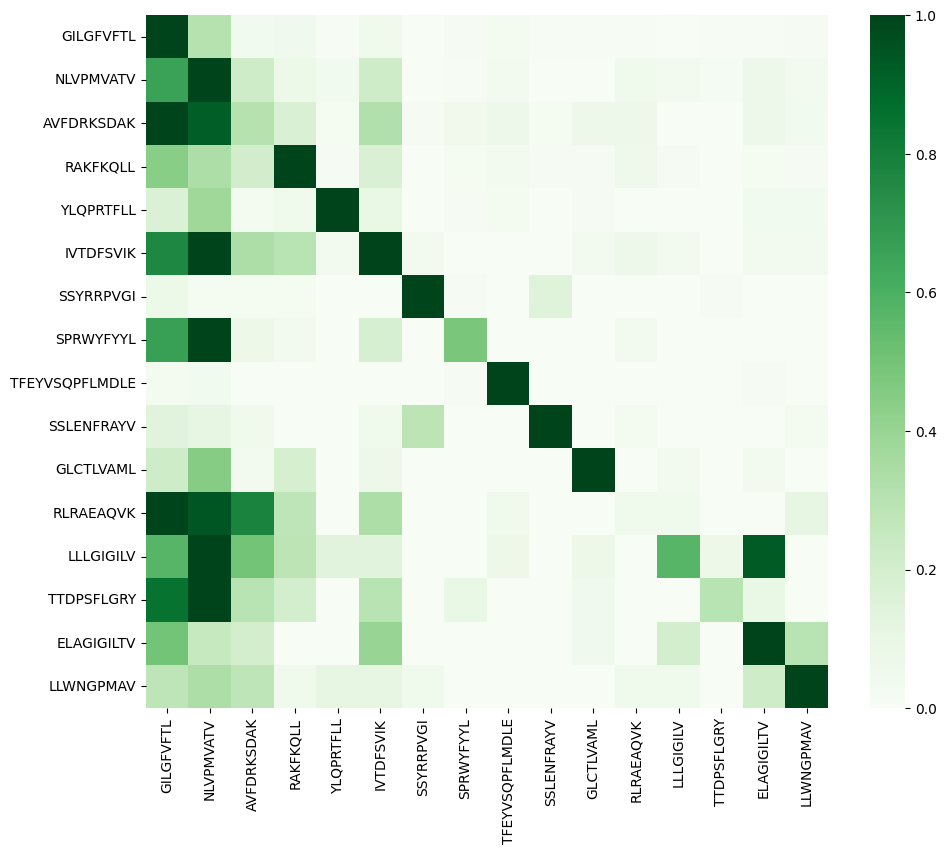

In [31]:
draw_heatmap(predictions, ans, le, N_LABELS, return_mtr=False)

### TCR-bert

In [32]:
epit_mod = CustomModel(n_labels=N_LABELS)

loading configuration file config.json from cache at /home/akabalina/.cache/huggingface/hub/models--wukevin--tcr-bert/snapshots/ef65ddcb4e549990e584680e27f9ae2618c884ff/config.json
Model config BertConfig {
  "_name_or_path": "wukevin/tcr-bert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LLWNGPMAV",
    "1": "RPRGEVRFL",
    "2": "ATDALMTGY",
    "3": "HSKKKCDEL",
    "4": "KAFSPEVIPMF",
    "5": "KRWIILGLNK",
    "6": "KRWIIMGLNK",
    "7": "TPQDLNTML",
    "8": "EIYKRWII",
    "9": "ISPRTL-W",
    "10": "FLKEKGGL",
    "11": "HPKVSSEVHI",
    "12": "IIKDYGKQM",
    "13": "LPPIVAKEI",
    "14": "RFPLTFGWCF",
    "15": "RYPLTFGWCF",
    "16": "TPGPGVRYPL",
    "17": "TQGYFPDWQNY",
    "18": "FPRPWLHGL",
    "19": "RYPLTFGW",
    "20": "ELRRKMMYM",
    "21": "QIKVRV

In [33]:
alpha_train.reset_index(drop=True, inplace=True)

In [34]:
input_ids, attention_masks, labels = epit_mod.tokenize(alpha_train['cdr3.alpha'], alpha_train['antigen.epitope'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [35]:
train_dataset, val_dataset = epit_mod.split_data(input_ids, attention_masks, labels)

8,036 training samples
2,009 validation samples


In [36]:
epit_mod.fit(train_dataset, val_dataset, epochs=5)


======== Epoch 1 / 5 ========
Training...

  Average training loss: 1.98
  Training epcoh took: 0:00:24

Running Validation...
  Accuracy: 0.43
  Validation Loss: 1.81
  Validation took: 0:00:01

======== Epoch 2 / 5 ========
Training...

  Average training loss: 1.67
  Training epcoh took: 0:00:24

Running Validation...
  Accuracy: 0.46
  Validation Loss: 1.75
  Validation took: 0:00:01

======== Epoch 3 / 5 ========
Training...

  Average training loss: 1.49
  Training epcoh took: 0:00:24

Running Validation...
  Accuracy: 0.47
  Validation Loss: 1.72
  Validation took: 0:00:01

======== Epoch 4 / 5 ========
Training...

  Average training loss: 1.34
  Training epcoh took: 0:00:24

Running Validation...
  Accuracy: 0.46
  Validation Loss: 1.76
  Validation took: 0:00:01

======== Epoch 5 / 5 ========
Training...

  Average training loss: 1.21
  Training epcoh took: 0:00:24

Running Validation...
  Accuracy: 0.46
  Validation Loss: 1.78
  Validation took: 0:00:01

Training complete!


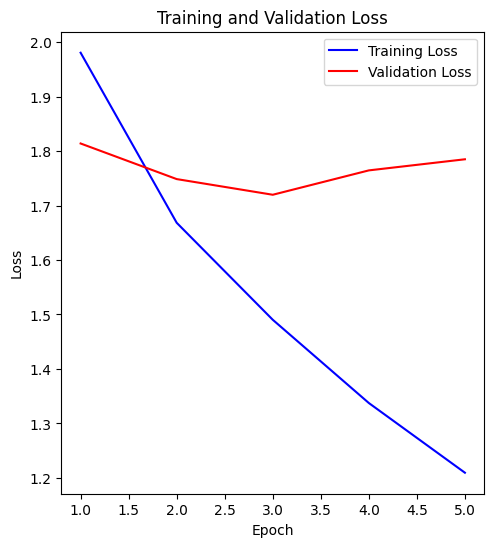

In [37]:
epit_mod.draw_stats_plot()

In [38]:
epit_mod.get_stats()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.980463,1.813848,0.431382,0:00:24,0:00:01
2,1.668295,1.748498,0.455688,0:00:24,0:00:01
3,1.490248,1.719741,0.466711,0:00:24,0:00:01
4,1.337433,1.764469,0.461640,0:00:24,0:00:01
5,1.209487,1.784856,0.463624,0:00:24,0:00:01


In [39]:
pred_labels = epit_mod.predict(alpha_test['sequence'])
f1_sc = f1_score(ans, pred_labels, average='macro')
print('Total f1_score: %.5f' % f1_sc)

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Total f1_score: 0.44133


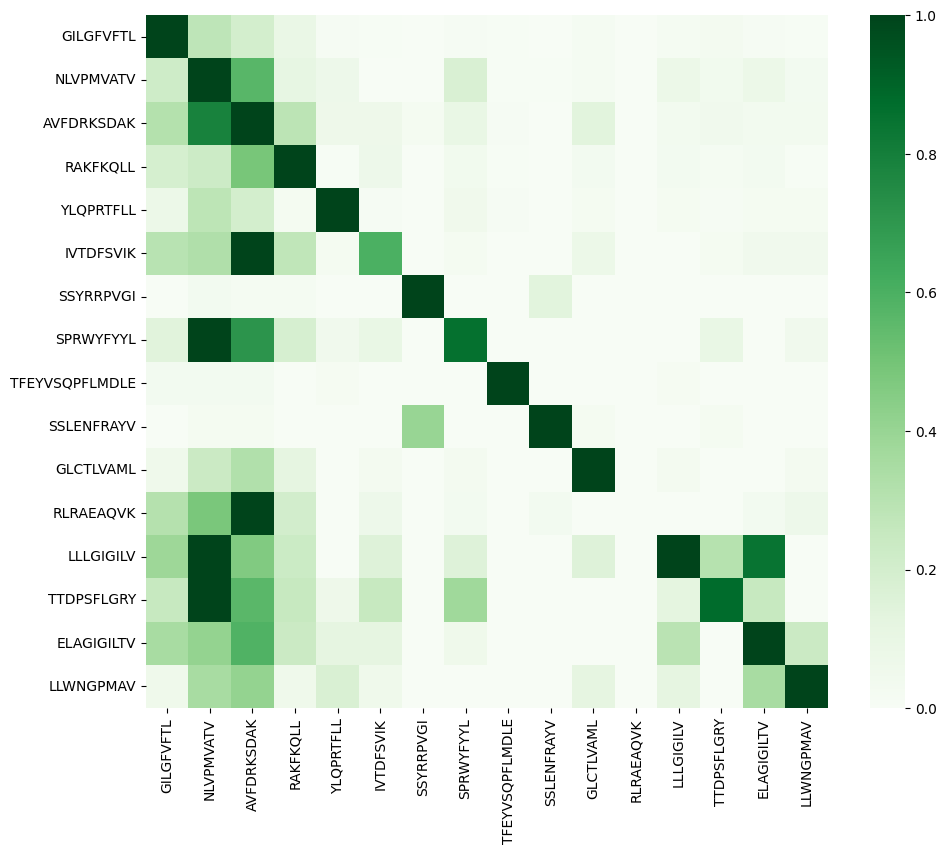

In [40]:
draw_heatmap(pred_labels, ans, le, N_LABELS, return_mtr=False)

In [41]:
save_model(epit_mod, '../models_ft/alpha_tct.pth')

## Beta 

In [6]:
vdjb_beta = vdjdb[['cdr3.beta', 'antigen.epitope']].dropna()
print(vdjb_beta.shape)
vdjb_beta = vdjb_beta[vdjb_beta['antigen.epitope'] != 'KLGGALQAK']
print(vdjb_beta.shape)

(54722, 2)
(40748, 2)


In [7]:
le_beta = MyLabelEncoder()
groups_beta = vdjb_beta['antigen.epitope'].value_counts().index

le_beta.fit(groups_beta)
# groups
le_beta.transform(groups_beta)

array([   0,    1,    2, ..., 1164, 1165, 1166])

In [8]:
vdjb_beta['antigen.epitope'].value_counts()[vdjb_beta['antigen.epitope'].value_counts()>450].shape[0]

16

In [9]:
vdjb_beta['antigen.epitope']= le_beta.transform(vdjb_beta['antigen.epitope'])
vdjb_beta

,cdr3.beta,antigen.epitope
0,CASSYLPGQGDHYSNQPQHF,33
1,CASSFEAGQGFFSNQPQHF,33
2,CASSFEPGQGFYSNQPQHF,33
3,CASSYEPGQVSHYSNQPQHF,33
4,CASSALASLNEQFF,33
...,...,...
62172,CASSVRSTDTQYF,128
62173,CASSLRYTDTQYF,128
62174,CASSPGQGGDNEQFF,239
62175,CASSLGAGGQETQYF,239


In [10]:
vdjb_beta = vdjb_beta[vdjb_beta['antigen.epitope']<16]

<BarContainer object of 16 artists>

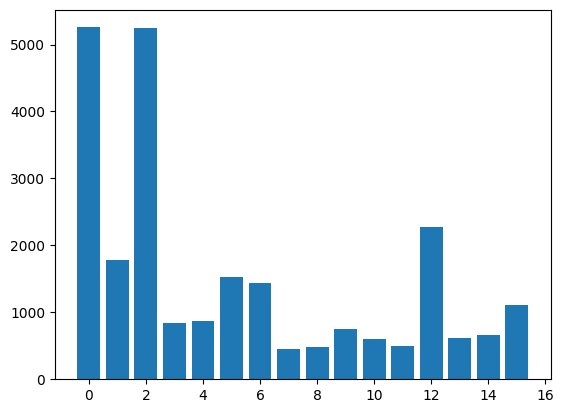

In [11]:
plt.bar(vdjb_beta['antigen.epitope'].unique(), vdjb_beta['antigen.epitope'].value_counts())

In [12]:
beta_data = vdjb_beta.reset_index(drop=True)

In [13]:
beta_data['antigen.epitope'].value_counts()

0     5258
1     5250
2     2282
3     1782
4     1521
5     1443
6     1114
7      873
8      847
9      757
10     661
11     610
12     595
13     495
14     477
15     456
Name: antigen.epitope, dtype: int64

In [14]:
beta_resampl = balance_majority(beta_data, 'antigen.epitope', max_count=1500)

In [15]:
beta_test = beta_resampl.sample(frac=0.15, random_state=42)
beta_train = beta_resampl.drop(beta_test.index)

beta_train

,cdr3.beta,antigen.epitope
2638,CSARDRIGNGYTF,5
2639,CSARDGTGNGYTF,5
2641,CSARSGVGNTIYF,5
2642,CSVGSTGGTNEKLFF,5
2643,CSVGSAGTNEKLFF,5
...,...,...
15598,CASSWGGGSHYGYTF,4
13018,CASDRQDFYSNQPQHF,4
15134,CASTDVRRVDGELFF,4
13827,CASSFQGLVSSYNEQFF,4


In [16]:
beta_train['cdr3.beta']  = beta_train['cdr3.beta'].apply(add_spaces)
beta_test['cdr3.beta']  = beta_test['cdr3.beta'].apply(add_spaces)

In [17]:
ans = beta_test['antigen.epitope']
beta_test = beta_test.drop(columns=['antigen.epitope'])

In [18]:
N_LABELS_beta = beta_train['antigen.epitope'].nunique()


In [19]:
N_LABELS_beta

16

### Prottrans

In [20]:
train_df, val_df = train_test_split(beta_train, test_size=0.2, random_state=42)

In [21]:
train_df = train_df.rename({'cdr3.beta': 'sequence', 'antigen.epitope': 'label'}, axis=1)
val_df = val_df.rename({'cdr3.beta': 'sequence', 'antigen.epitope': 'label'}, axis=1)
train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
val_df["sequence"]=val_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    
val_df

,sequence,label
12328,C A S S W G G G S H Y G Y T F,9
12598,C A T G T G D S N Q P Q H F,3
10056,C A S S P L D T K Q Q F F,1
6457,C A S S Y S T D T Q Y F,0
12187,C A S S W G G G S H Y G Y T F,9
...,...,...
7945,C A S R T V N P P L H F,1
12404,C A S S L N G Q G A G Y T F,9
16392,C A S R G W E S N T E A F F,9
22455,C A S S Y S V P A L G N T I Y F,5


In [22]:
tokenizer, model, history = train_per_protein(train_df, val_df, num_labels=N_LABELS_beta, epochs=10)

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.18.layer.2.DenseReluDense.wi.weight', 'decoder.block.16.layer.0.SelfAttention.o.weight', 'decoder.block.0.layer.1.EncDecAttention.q.weight', 'decoder.block.10.layer.1.EncDecAttention.o.weight', 'decoder.block.10.layer.2.layer_norm.weight', 'decoder.block.23.layer.2.layer_norm.weight', 'decoder.block.19.layer.1.EncDecAttention.v.weight', 'decoder.block.4.layer.1.EncDecAttention.k.weight', 'decoder.block.14.layer.1.layer_norm.weight', 'decoder.block.22.layer.2.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.q.weight', 'decoder.block.13.layer.1.layer_norm.weight', 'decoder.block.3.layer.1.EncDecAttention.o.weight', 'decoder.block.21.layer.0.SelfAttention.v.weight', 'decoder.block.15.layer.1.EncDecAttention.o.weight', 'decoder.block.14.layer.0.SelfAttention.v.weight', 'decoder.block.2.layer.0.SelfAttention.k.weight', 'decoder.block.23.layer.2.DenseR

ProtT5_Classfier
Trainable Parameter: 1209207824
ProtT5_LoRA_Classfier
Trainable Parameter: 3573776

[2024-05-10 00:54:39,242] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-05-10 00:54:39,244] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
[2024-05-10 00:54:39,255] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.14.0, git-hash=unknown, git-branch=unknown
[2024-05-10 00:54:41,967] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False


Using /home/akabalina/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/akabalina/.cache/torch_extensions/py39_cu117/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module cpu_adam...


ninja: no work to do.
Time to load cpu_adam op: 3.4433510303497314 seconds
[2024-05-10 00:54:48,674] [INFO] [logging.py:96:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adamw as basic optimizer
[2024-05-10 00:54:48,676] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2024-05-10 00:54:48,719] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
[2024-05-10 00:54:48,720] [INFO] [utils.py:56:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
[2024-05-10 00:54:48,721] [INFO] [logging.py:96:log_dist] [Rank 0] Creating torch.float32 ZeRO stage 2 optimizer
[2024-05-10 00:54:48,722] [INFO] [stage_1_and_2.py:149:__init__] Reduce bucket size 200000000
[2024-05-10 00:54:48,723] [INFO] [stage_1_and_2.py:150:__init__] Allgather bucket size 200000000
[2024-05-10 00:54:48,723] [INFO] [stage_1_and_2.py:151:__ini

***** Running training *****
  Num examples = 10763
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 2
  Total optimization steps = 13450
  Number of trainable parameters = 3573776


Adam Optimizer #0 is created with AVX512 arithmetic capability.
Config: alpha=0.000300, betas=(0.900000, 0.999000), weight_decay=0.000000, adam_w=1


Epoch,Training Loss,Validation Loss,Accuracy
0,2.143800,1.901835,0.386845
1,1.824200,1.761248,0.431438
2,1.706200,1.716760,0.452991
3,1.609000,1.709212,0.465255
4,1.523600,1.676806,0.483463
5,1.463100,1.674622,0.484578
6,1.394500,1.693310,0.486808
7,1.330100,1.672552,0.494612
8,1.274100,1.728216,0.503530
9,1.197300,1.733146,0.501301


***** Running Evaluation *****
  Num examples = 2691
  Batch size = 16


[2024-05-10 01:08:28,878] [INFO] [logging.py:96:log_dist] [Rank 0] step=2000, skipped=0, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-05-10 01:08:28,882] [INFO] [timer.py:260:stop] epoch=0/micro_step=4000/global_step=2000, RunningAvgSamplesPerSec=20.70433230786087, CurrSamplesPerSec=20.676301187112756, MemAllocated=4.53GB, MaxMemAllocated=8.2GB


***** Running Evaluation *****
  Num examples = 2691
  Batch size = 16


[2024-05-10 01:22:06,681] [INFO] [logging.py:96:log_dist] [Rank 0] step=4000, skipped=0, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-05-10 01:22:06,683] [INFO] [timer.py:260:stop] epoch=0/micro_step=8000/global_step=4000, RunningAvgSamplesPerSec=20.716992730198655, CurrSamplesPerSec=20.808988791917134, MemAllocated=4.53GB, MaxMemAllocated=8.2GB


***** Running Evaluation *****
  Num examples = 2691
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2691
  Batch size = 16


[2024-05-10 01:36:07,427] [INFO] [logging.py:96:log_dist] [Rank 0] step=6000, skipped=0, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-05-10 01:36:07,430] [INFO] [timer.py:260:stop] epoch=0/micro_step=12000/global_step=6000, RunningAvgSamplesPerSec=20.716542880702402, CurrSamplesPerSec=20.71431296520023, MemAllocated=4.53GB, MaxMemAllocated=8.2GB


***** Running Evaluation *****
  Num examples = 2691
  Batch size = 16


[2024-05-10 01:49:46,025] [INFO] [logging.py:96:log_dist] [Rank 0] step=8000, skipped=0, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-05-10 01:49:46,029] [INFO] [timer.py:260:stop] epoch=0/micro_step=16000/global_step=8000, RunningAvgSamplesPerSec=20.720628570850796, CurrSamplesPerSec=20.66755197926496, MemAllocated=4.53GB, MaxMemAllocated=8.2GB


***** Running Evaluation *****
  Num examples = 2691
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2691
  Batch size = 16


[2024-05-10 02:03:46,273] [INFO] [logging.py:96:log_dist] [Rank 0] step=10000, skipped=0, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-05-10 02:03:46,277] [INFO] [timer.py:260:stop] epoch=0/micro_step=20000/global_step=10000, RunningAvgSamplesPerSec=20.717349139656623, CurrSamplesPerSec=20.63199473661557, MemAllocated=4.53GB, MaxMemAllocated=8.2GB


***** Running Evaluation *****
  Num examples = 2691
  Batch size = 16


[2024-05-10 02:17:25,182] [INFO] [logging.py:96:log_dist] [Rank 0] step=12000, skipped=0, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-05-10 02:17:25,184] [INFO] [timer.py:260:stop] epoch=0/micro_step=24000/global_step=12000, RunningAvgSamplesPerSec=20.717345293749485, CurrSamplesPerSec=20.56211543045745, MemAllocated=4.53GB, MaxMemAllocated=8.2GB


***** Running Evaluation *****
  Num examples = 2691
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2691
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




In [23]:
save_model(model, '../models_ft/prottrans_beta_epit.pth')

In [24]:
tock, model_re = load_model_('../models_ft/prottrans_beta_epit.pth', num_labels=N_LABELS_beta)

loading configuration file config.json from cache at /home/akabalina/.cache/huggingface/hub/models--Rostlab--prot_t5_xl_uniref50/snapshots/973be27c52ee6474de9c945952a8008aeb2a1a73/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 16384,
  "d_kv": 128,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 32,
  "num_layers": 24,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.26.1",
  "use_cache": true,
  "vocab_size": 128
}

loading weights file pytorch_model.bin from cache at /home/akabalina/.cache/huggingface/hub/models--Rostlab--p

ProtT5_Classfier
Trainable Parameter: 1209207824
ProtT5_LoRA_Classfier
Trainable Parameter: 3573776



In [25]:
beta_test=beta_test.rename({'cdr3.beta': 'sequence'}, axis=1)
beta_test["sequence"]=beta_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)

beta_test.head(5)

,sequence
13158,C A S S Y G E G S Y E Q Y F
9661,C A S S Y S A S G G E Q F F
19168,C A S S I E Q Y Y E Q Y F
23524,C S V D R G S P S Y E Q Y F
15014,C A S S V R S S Y E Q Y F


In [26]:
# create Dataset
test_set=create_dataset(tock, list(beta_test['sequence']),list(ans))

test_set = test_set.with_format("torch", device=device)
test_dataloader = DataLoader(test_set, batch_size=8, shuffle=False)


model_re.eval()

# Make predictions on the test dataset
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #add batch results(logits) to predictions
        predictions += model_re(input_ids, attention_mask=attention_mask).logits.tolist()

100%|██████████| 297/297 [00:21<00:00, 13.93it/s]


In [27]:
predictions= [item.argmax() for item in np.array(predictions)]
print("F1 score: ", f1_score(list(ans), predictions, average='macro'))

F1 score:  0.5382808609697813


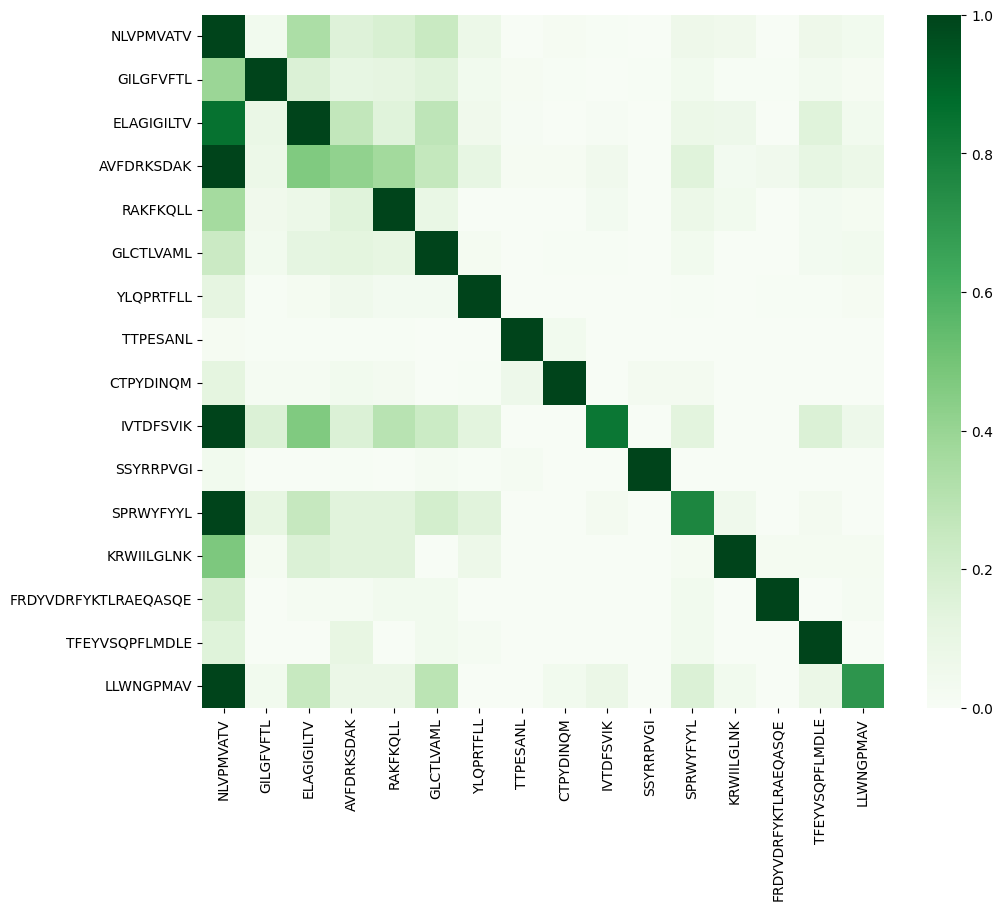

In [28]:
draw_heatmap(predictions, ans, le_beta, N_LABELS_beta, return_mtr=False)

### TCR-bert

In [29]:
epit_mod_beta = CustomModel(n_labels=N_LABELS_beta)

loading configuration file config.json from cache at /home/akabalina/.cache/huggingface/hub/models--wukevin--tcr-bert/snapshots/ef65ddcb4e549990e584680e27f9ae2618c884ff/config.json
Model config BertConfig {
  "_name_or_path": "wukevin/tcr-bert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LLWNGPMAV",
    "1": "RPRGEVRFL",
    "2": "ATDALMTGY",
    "3": "HSKKKCDEL",
    "4": "KAFSPEVIPMF",
    "5": "KRWIILGLNK",
    "6": "KRWIIMGLNK",
    "7": "TPQDLNTML",
    "8": "EIYKRWII",
    "9": "ISPRTL-W",
    "10": "FLKEKGGL",
    "11": "HPKVSSEVHI",
    "12": "IIKDYGKQM",
    "13": "LPPIVAKEI",
    "14": "RFPLTFGWCF",
    "15": "RYPLTFGWCF",
    "16": "TPGPGVRYPL",
    "17": "TQGYFPDWQNY",
    "18": "FPRPWLHGL",
    "19": "RYPLTFGW",
    "20": "ELRRKMMYM",
    "21": "QIKVRV

In [30]:
beta_train.reset_index(drop=True, inplace=True)

In [31]:
input_ids, attention_masks, labels = epit_mod_beta.tokenize(beta_train['cdr3.beta'], beta_train['antigen.epitope'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [32]:
train_dataset, val_dataset = epit_mod_beta.split_data(input_ids, attention_masks, labels)

10,763 training samples
2,691 validation samples


In [33]:
epit_mod_beta.fit(train_dataset, val_dataset, epochs=5)


======== Epoch 1 / 5 ========
Training...

  Average training loss: 1.87
  Training epcoh took: 0:00:32

Running Validation...
  Accuracy: 0.46
  Validation Loss: 1.66
  Validation took: 0:00:02

======== Epoch 2 / 5 ========
Training...

  Average training loss: 1.50
  Training epcoh took: 0:00:32

Running Validation...
  Accuracy: 0.50
  Validation Loss: 1.58
  Validation took: 0:00:02

======== Epoch 3 / 5 ========
Training...

  Average training loss: 1.28
  Training epcoh took: 0:00:32

Running Validation...
  Accuracy: 0.52
  Validation Loss: 1.57
  Validation took: 0:00:02

======== Epoch 4 / 5 ========
Training...

  Average training loss: 1.08
  Training epcoh took: 0:00:32

Running Validation...
  Accuracy: 0.54
  Validation Loss: 1.56
  Validation took: 0:00:02

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.92
  Training epcoh took: 0:00:32

Running Validation...
  Accuracy: 0.54
  Validation Loss: 1.58
  Validation took: 0:00:02

Training complete!


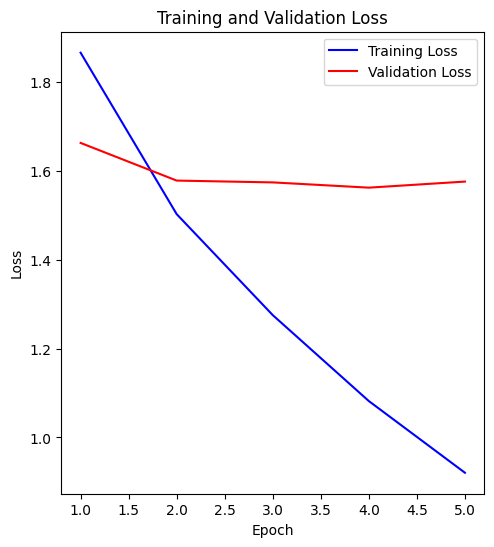

In [34]:
epit_mod_beta.draw_stats_plot()

In [35]:
epit_mod_beta.get_stats()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.865123,1.662304,0.464744,0:00:32,0:00:02
2,1.502143,1.577630,0.503945,0:00:32,0:00:02
3,1.275138,1.573564,0.519477,0:00:32,0:00:02
4,1.081915,1.561749,0.536119,0:00:32,0:00:02
5,0.920798,1.575381,0.543146,0:00:32,0:00:02


In [72]:
epit_mod_beta = load_model_('../models_ft/beta_tcr_bert_epit_model.pth', mod_type='TCR-bert', num_labels=N_LABELS_beta)
epit_mod_beta.maximun_len = 40
epit_mod_beta.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([21, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([21]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomModel(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(26, 768, padding_idx=21)
        (position_embeddings): Embedding(64, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=

In [36]:
pred_labels = epit_mod_beta.predict(beta_test['sequence'])
f1_sc = f1_score(ans, pred_labels, average='macro')
print('Total f1_score: %.5f' % f1_sc)

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Total f1_score: 0.57244


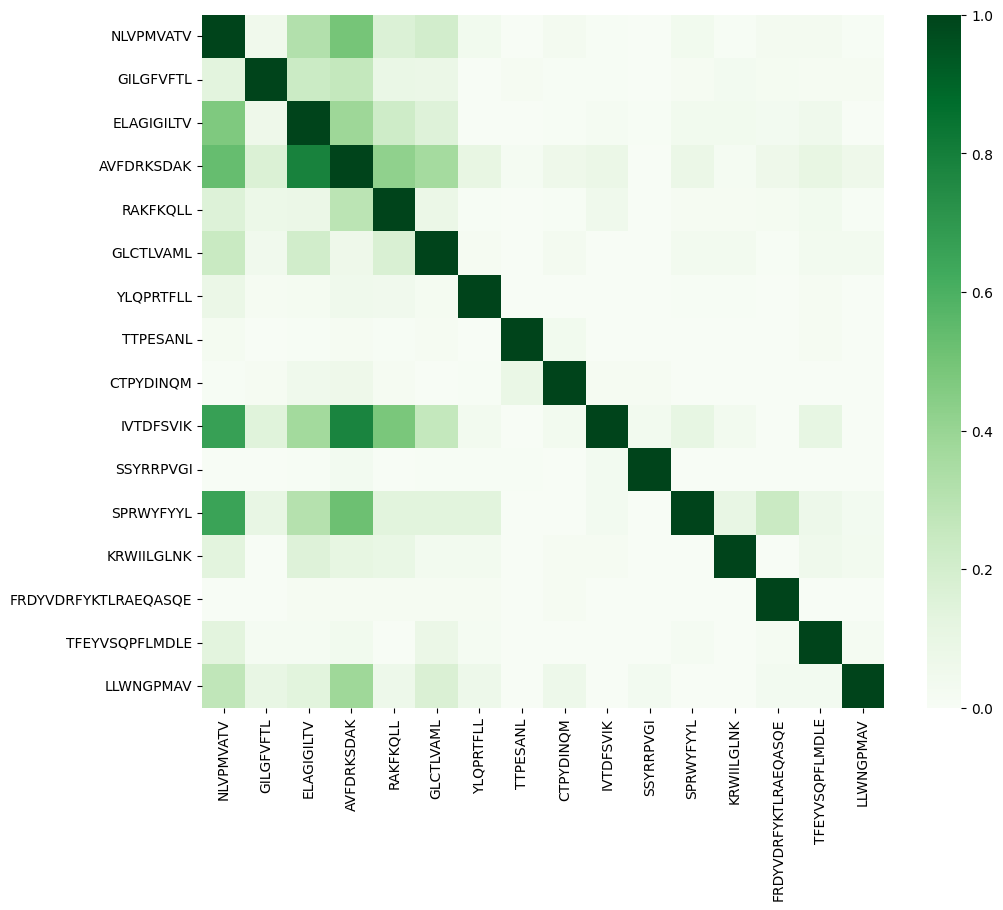

In [37]:
draw_heatmap(pred_labels, ans, le_beta, N_LABELS_beta, return_mtr=False)

In [38]:
save_model(epit_mod_beta, '../models_ft/beta_tcr_bert_epit_model.pth')